# XGBoost Parameter Tuning for Otto Dataset

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

# 第五步：调整正则化参数：reg_alpha 和reg_lambda

首先 import 必要的模块

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [2]:
# path to where the data lies
dpath = '../data/'
train = pd.read_csv(dpath +"Otto_train.csv")
#train.head()

## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

## Target 分布，看看各类样本分布是否均衡

In [3]:
#sns.countplot(train.target);
#pyplot.xlabel('target');
#pyplot.ylabel('Number of occurrences');

每类样本分布不是很均匀，所以交叉验证时也考虑各类样本按比例抽取

In [4]:
# drop ids and get labels
y_train = train['target']
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [5]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

第二轮参数调整得到的n_estimators最优值（645），其余参数继续默认值

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss，neg_mean_squared_error 详见sklearn文档：http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

In [6]:
#reg_alpha = [1e-3, 1e-2, 0.05, 0.1]    #default = 0
#reg_lambda = [1e-3, 1e-2, 0.05, 0.1]   #default = 1

reg_alpha = [ 1.5, 2]    #default = 0, 测试0.1,1，1.5，2
reg_lambda = [0.5, 1, 2]      #default = 1，测试0.1， 0.5， 1，2

param_test5_1 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)
param_test5_1


{'reg_alpha': [1.5, 2], 'reg_lambda': [0.5, 1, 2]}

In [7]:
xgb5_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=645,  #第二轮参数调整得到的n_estimators最优值
        max_depth=6,
        min_child_weight=4,
        gamma=0,
        subsample=0.7,
        colsample_bytree=0.6,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch5_1 = GridSearchCV(xgb5_1, param_grid = param_test5_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch5_1.fit(X_train , y_train)

gsearch5_1.best_params_,     gsearch5_1.best_score_

({'reg_alpha': 1.5, 'reg_lambda': 0.5}, -0.4601744648673406)

In [8]:
gsearch5_1.cv_results_

/usr/local/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/python3/lib/python3.6/site-packa

{'mean_fit_time': array([ 950.57670879,  980.53163352, 1028.46014452, 1024.81334534,
         993.26170092,  827.82961688]),
 'std_fit_time': array([10.25493463, 45.69625824,  4.0514189 ,  3.25786986, 78.71033406,
         4.38836662]),
 'mean_score_time': array([19.00895467, 17.65138917, 17.2968657 , 17.348312  , 16.25535197,
        12.51994114]),
 'std_score_time': array([1.07436461, 1.74580988, 2.39173054, 2.33465803, 2.22205709,
        0.17023584]),
 'param_reg_alpha': masked_array(data=[1.5, 1.5, 1.5, 2, 2, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_reg_lambda': masked_array(data=[0.5, 1, 2, 0.5, 1, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'reg_alpha': 1.5, 'reg_lambda': 0.5},
  {'reg_alpha': 1.5, 'reg_lambda': 1},
  {'reg_alpha': 1.5, 'reg_lambda': 2},
  {'reg_alpha': 2, 'reg_lambda': 0.5},
  {'reg_alpha':

Best: -0.460174 using {'reg_alpha': 1.5, 'reg_lambda': 0.5}


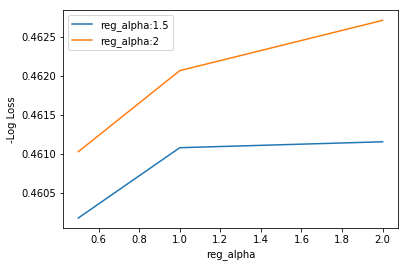

In [9]:
# summarize results
print("Best: %f using %s" % (gsearch5_1.best_score_, gsearch5_1.best_params_))
test_means = gsearch5_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch5_1.cv_results_[ 'std_test_score' ]
train_means = gsearch5_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch5_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch5_1.cv_results_).to_csv('my_preds_reg_alpha_reg_lambda_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(reg_alpha), len(reg_lambda))
train_scores = np.array(train_means).reshape(len(reg_alpha), len(reg_lambda))

#log_reg_alpha = [0,0,0,0]
#for index in range(len(reg_alpha)):
#   log_reg_alpha[index] = math.log10(reg_alpha[index])
    
for i, value in enumerate(reg_alpha):
    pyplot.plot(reg_lambda, -test_scores[i], label= 'reg_alpha:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'reg_alpha' )                                                                                                      
pyplot.ylabel( '-Log Loss' )
pyplot.savefig( 'reg_alpha_vs_reg_lambda1.png' )